In [1]:
import category_encoders as ce
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn import neighbors
from sklearn import multiclass
from scipy import sparse
from pandas.plotting import scatter_matrix
from scipy import stats
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import cross_val_score,StratifiedShuffleSplit
from sklearn.model_selection import StratifiedKFold
from sklearn import ensemble
from sklearn import naive_bayes
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis,QuadraticDiscriminantAnalysis
from sklearn import metrics
from sklearn.model_selection import train_test_split
import seaborn as sns
import pandas as pd
import numpy as np

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


Let's import the dataset.

In [ ]:
data = pd.read_csv('SpotfiyFeatures.csv')

We randomize the data first

In [2]:
data = data.sample(frac=1)

Remove any duplicate songs in different genres

In [3]:
column_split = (set(data.columns))
column_split.remove('genre')
data = data.drop_duplicates(subset=list(column_split))

In [4]:
data.describe()

,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
count,191056.000000,191056.000000,191056.000000,1.910560e+05,191056.000000,191056.000000,191056.00000,191056.000000,191056.000000,191056.000000,191056.000000
mean,37.593517,0.390859,0.541802,2.359893e+05,0.564349,0.165507,0.22197,-9.944462,0.123924,117.426531,0.452894
std,17.600902,0.364142,0.188193,1.271222e+05,0.273886,0.317504,0.20747,6.296627,0.198276,31.234839,0.265445
min,0.000000,0.000000,0.056900,1.538700e+04,0.000020,0.000000,0.00967,-52.457000,0.022200,30.379000,0.000000
25%,26.000000,0.039400,0.418000,1.799070e+05,0.359000,0.000000,0.09740,-12.519000,0.036700,92.176250,0.227000
50%,39.000000,0.264000,0.558000,2.199105e+05,0.601000,0.000068,0.13000,-8.023000,0.049300,115.107500,0.442000
75%,50.000000,0.772000,0.681000,2.678600e+05,0.794000,0.071700,0.27400,-5.550000,0.099800,139.006250,0.665000
max,100.000000,0.996000,0.989000,5.552917e+06,0.999000,0.999000,1.00000,3.744000,0.967000,242.903000,1.000000


In [5]:
data['genre'].value_counts()

Comedy              9675
Alternative         9259
Electronic          9161
Classical           9018
Anime               8935
Soundtrack          8833
Folk                8798
Blues               8773
Reggae              8712
Dance               8657
Jazz                8568
Reggaeton           8551
Opera               8280
World               8186
Hip-Hop             8042
Ska                 8030
Movie               7803
Country             7775
R&B                 6946
Children’s Music    6695
Children's Music    5403
Soul                4912
Indie               3993
Pop                 3166
Rock                3081
Rap                 1685
A Capella            119
Name: genre, dtype: int64

So, we're noticing that A-capella has significantly less songs in that genre, we can either try merging it with another genre, getting more songs of that genre, or simply dropping it. For rn, let's simply drop it. The children's music also is split between Children's Music and Children’s Music let's combine those.

In [6]:
data =data.drop(data[data['genre'] == 'A Capella'].index)
data['genre'].value_counts()

Comedy              9675
Alternative         9259
Electronic          9161
Classical           9018
Anime               8935
Soundtrack          8833
Folk                8798
Blues               8773
Reggae              8712
Dance               8657
Jazz                8568
Reggaeton           8551
Opera               8280
World               8186
Hip-Hop             8042
Ska                 8030
Movie               7803
Country             7775
R&B                 6946
Children’s Music    6695
Children's Music    5403
Soul                4912
Indie               3993
Pop                 3166
Rock                3081
Rap                 1685
Name: genre, dtype: int64

In [7]:
replace_Children = {'genre':     {"Children's Music": 'Children’s Music'}}
data = data.replace(replace_Children)
data['genre'].value_counts()

Children’s Music    12098
Comedy               9675
Alternative          9259
Electronic           9161
Classical            9018
Anime                8935
Soundtrack           8833
Folk                 8798
Blues                8773
Reggae               8712
Dance                8657
Jazz                 8568
Reggaeton            8551
Opera                8280
World                8186
Hip-Hop              8042
Ska                  8030
Movie                7803
Country              7775
R&B                  6946
Soul                 4912
Indie                3993
Pop                  3166
Rock                 3081
Rap                  1685
Name: genre, dtype: int64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2d630a7150>,
      dtype=object)

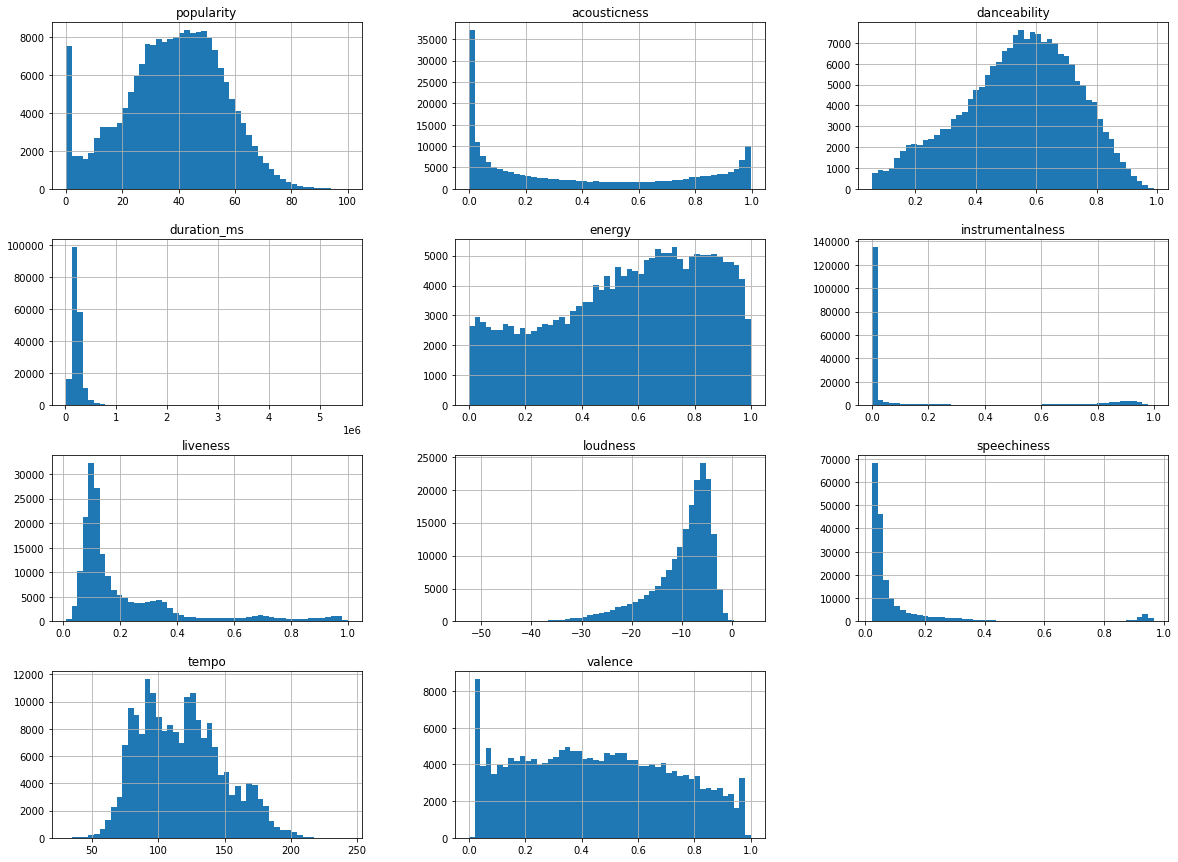

In [8]:
data.hist(bins=50,figsize=(20,15))

So we're noticing that speechiness, loudness,duration,liveness, and instrumentalness are a bit skewed let's check this to be sure.

In [9]:
data.skew(axis = 0, skipna = True)

popularity         -0.199448
acousticness        0.425620
danceability       -0.332461
duration_ms         9.565596
energy             -0.360381
instrumentalness    1.640564
liveness            1.987244
loudness           -1.527640
speechiness         3.199962
tempo               0.404330
valence             0.145504
dtype: float64

This confirms our suspicions so far, there's definitedly some skewedness going on in those columns lets apply some log transforms to see if this works 

In [10]:
data['duration_ms'] =  np.log(data['duration_ms'])
data['duration_ms'].skew()

-0.46015737744988033

That fixed duration_ms let's try speechiness, log didn't work on this so we'll use boxcox

In [11]:
data['speechiness'] = stats.boxcox(data['speechiness'])[0]
data['speechiness'].skew()

0.31245261459621987

Instrumentalness has 0 values so in order to log it we need to add a constant.

In [12]:
data['instrumentalness'] =  np.log(data['instrumentalness']+0.00000001)
data['instrumentalness'].skew()

0.007224877934534901

Loudness can vary postively and negatively at values up to 60 so lets add a constant

In [13]:
data['loudness'] =  stats.boxcox((data['loudness']+100))[0]
data['loudness'].skew()

-0.23736423057249675

Let's use the boxcox method this as it's left skewed.

In [14]:
data['liveness'] =  stats.boxcox(data['liveness']+0.0000001)[0]
data['liveness'].skew()

0.034250611977714694

Let's put this in the dataset and check the full dataset again.

In [15]:
data.skew()

popularity         -0.199448
acousticness        0.425620
danceability       -0.332461
duration_ms        -0.460157
energy             -0.360381
instrumentalness    0.007225
liveness            0.034251
loudness           -0.237364
speechiness         0.312453
tempo               0.404330
valence             0.145504
dtype: float64

Let's remove all of the columns we don't need,NOTE: We currently do not store popularity of tracks but it would not be diffucult to store it. Let's keep it for now, and if does have a signficant effect on the metrics going forward we'll use it.

In [16]:
if 'artist_name' in data.columns or 'track_id' in data.columns or 'track_name' in data.columns:
    column_split.remove('artist_name')
    column_split.remove('track_name')
    column_split.remove('track_id')
    data = data.drop(['artist_name', 'track_name','track_id'], axis=1)

We need to to do some encoding for the categorical features , so let's start with the key. Let's get all of the values.

In [17]:
data['key'].unique()

array(['C#', 'F#', 'C', 'F', 'G', 'E', 'D#', 'G#', 'D', 'A#', 'A', 'B'],
      dtype=object)

In [18]:
data['mode'].unique()

array(['Major', 'Minor'], dtype=object)

In [19]:
data['time_signature'].unique()

array(['4/4', '5/4', '3/4', '1/4', '0/4'], dtype=object)

Spotify uses pitch encoding to encode keys so we'll use the find and replace from pandas.

In [20]:
encode = {'mode':     {'Major': 1, 'Minor': 0},
                'time_signature' :{'5/4': 5, '4/4' : 4, 
                                   '3/4': 3, '2/4': 2, 
                                   '1/4' : 1, '0/4' : 0},
                'key': {'G': 7, 'E': 4, 'A': 9, 'B': 11,
                        'F': 5, 'G#': 8, 'C':0, 'C#': 1, 
                        'D':2, 'D#':3, 'F#': 6, 'A#' : 10}}
data = data.replace(encode)

Let's do a check on the encoded values.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2d62d7fb10>,
      dtype=object)

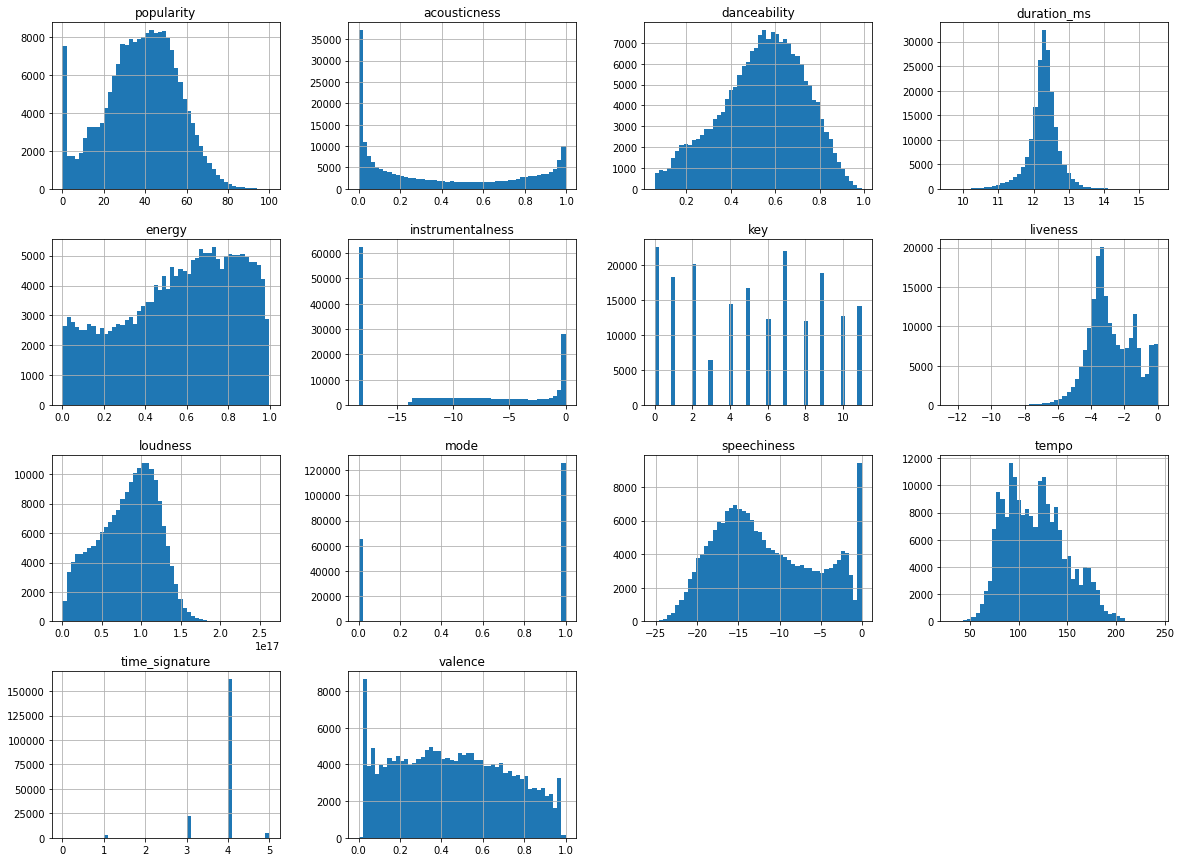

In [21]:
data.hist(bins=50,figsize=(20,15))

Time signature looks pretty skewed let's check.

In [22]:
data.skew()

popularity         -0.199448
acousticness        0.425620
danceability       -0.332461
duration_ms        -0.460157
energy             -0.360381
instrumentalness    0.007225
key                 0.016003
liveness            0.034251
loudness           -0.237364
mode               -0.667720
speechiness         0.312453
tempo               0.404330
time_signature     -2.970230
valence             0.145504
dtype: float64

Yep, let's add a constant and try the boxcox

In [23]:
data['time_signature'] = stats.boxcox(data['time_signature'] + 0.1)[0]
data['time_signature'].skew()

0.4735020588507424

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2d641ab9d0>,
      dtype=object)

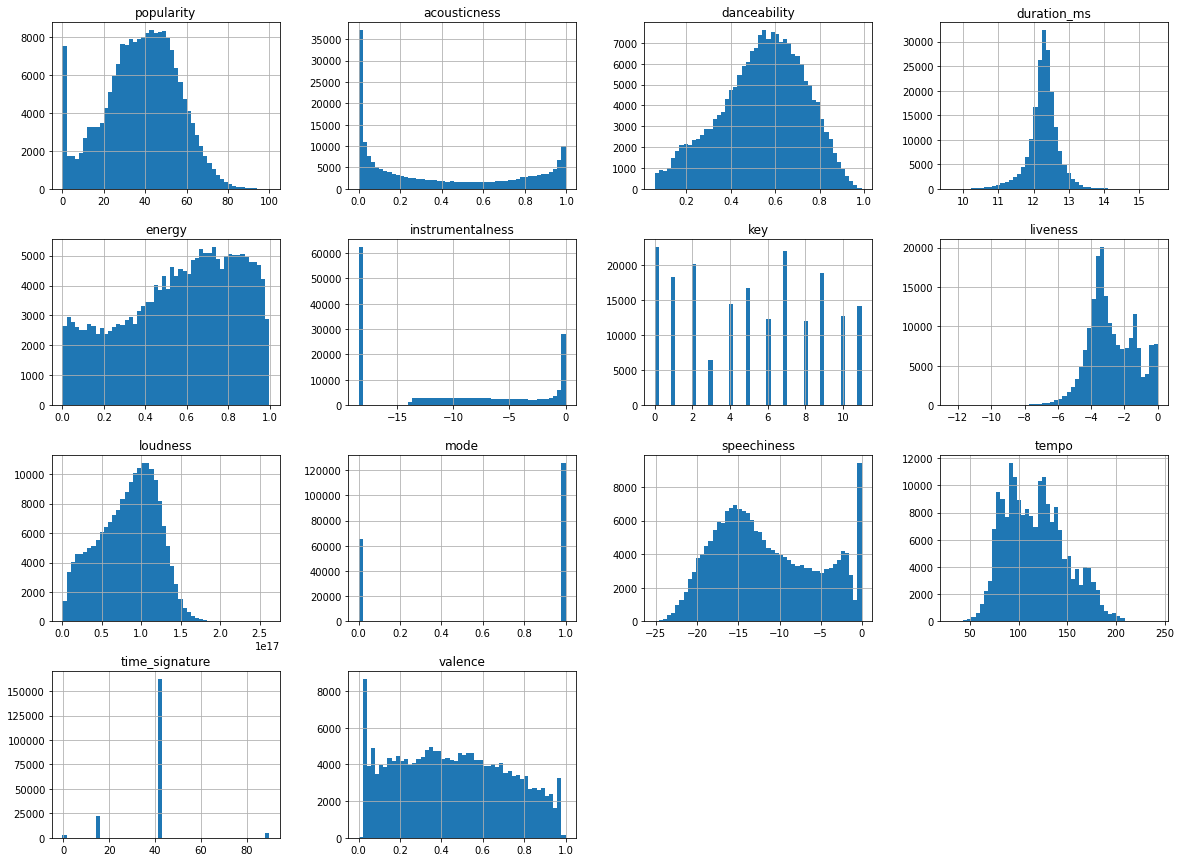

In [24]:
data.hist(bins=50,figsize=(20,15))

While we're doing some data analysis, let's use a one hot encoder to make stuff easier to see(we'll use binary encoders laters)

In [25]:
encoder = ce.one_hot.OneHotEncoder(cols=['genre'],return_df=True, use_cat_names=True)
one_hot = encoder.fit_transform(data['genre'])
one_hot_df = pd.DataFrame(one_hot)
test_data  = pd.concat([data[column_split], one_hot_df], 
          axis=1)

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [26]:
corr_matrix = test_data.corr()
for genre in one_hot_df.columns:
    print(f"Genre:{genre}\n")
    print(f'{corr_matrix[genre].sort_values(ascending=False)}' )

Genre:genre_Movie

genre_Movie               1.000000
acousticness              0.174014
mode                      0.043897
liveness                  0.022250
valence                  -0.004060
key                      -0.009799
genre_Rap                -0.019477
tempo                    -0.023032
time_signature           -0.024050
genre_Rock               -0.026435
genre_Pop                -0.026803
genre_Indie              -0.030168
genre_Soul               -0.033542
speechiness              -0.034051
instrumentalness         -0.035751
genre_R&B                -0.040107
genre_Country            -0.042528
genre_Ska                -0.043250
genre_Hip-Hop            -0.043284
genre_World              -0.043687
genre_Opera              -0.043948
genre_Reggaeton          -0.044695
genre_Jazz               -0.044741
genre_Dance              -0.044984
genre_Reggae             -0.045134
genre_Blues              -0.045299
genre_Folk               -0.045367
genre_Soundtrack         -0.045461
g

We could use seaborn's pairplots function but with this many features seaborn can be notriously slow.

In [ ]:
Yval = pd.DataFrame(one_hot)
Xval = data[column_split]
for x_name,val in Xval.iteritems():
    for name, values in Yval.iteritems():
        plot = plt.figure()
        plt.scatter(Xval[x_name],Yval[name])
        plt.xlabel(x_name) 
        plt.ylabel(name) 
        z = np.polyfit(Xval[str(x_name)],Yval[str(name)], 1)
        p = np.poly1d(z)
        plt.plot(Xval[x_name],p(Xval[x_name]),"r--")
        plt.title(f'{x_name} vs {name}:{Xval[x_name].corr(Yval[name])}') 
        plt.show()
        plot.savefig(f'Plots/{x_name} vs {name}.png')
        plt.close()

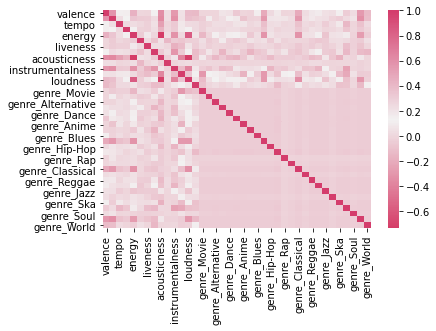

In [27]:
sns.heatmap(corr_matrix,cmap=sns.diverging_palette(-359, 359, n=300))

Seaborn can be really slow, so we're just going to graph a sample of the data.

Lets split the data into x and y portions, 

In [39]:
Xval = data[column_split].to_numpy()
Yval = data['genre'].to_numpy()

Genre is categorical data, so we need to encode it, and unfortunately there are ~300 genres to work with so we can't just use One hot encoding for the actual model so we'll use binary encoding instead

In [40]:
x_train, x_test, y_train, y_test = train_test_split (Xval, Yval, test_size = 0.2, random_state = 2)

In [41]:
scaler = preprocessing.StandardScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)

In [50]:
def eval_model(model,x_train,x_test,y_train,y_test):
  scores = cross_val_score (model, x_train, y_train, cv= 4, scoring = 'f1_macro', n_jobs= 8 )
  print ('f1 macro %s' % str (np.mean(scores)))
  scores = cross_val_score (model, x_train, y_train, cv = 4, scoring = 'precision_macro', n_jobs = 8)
  print ('precision macro %s' % str (np.mean(scores)))
  scores = cross_val_score (model, x_train, y_train, cv = 4, scoring = 'recall_macro', n_jobs = 8)
  print ('recall macro %s' % str (np.mean(scores)))
  model.fit(x_train,y_train)
  x_test = scaler.transform(x_test)
  y_pred = model.predict(x_test)
  metric= metrics.classification_report (y_pred,y_test)
  print (metric)
  print(f"Metrics: {metrics.f1_score(y_test, y_pred, average='macro')}")
  print(f" {metrics.accuracy_score(y_test, y_pred)}")

In [43]:
model = QuadraticDiscriminantAnalysis()
eval_model(model,x_train,x_test,y_train,y_test)

f1 macro 0.3719801827686585
precision macro 0.40009207812834846
recall macro 0.3894190074148793
                  precision    recall  f1-score   support

     Alternative       0.26      0.25      0.25      1900
           Anime       0.22      0.49      0.30       797
           Blues       0.25      0.39      0.30      1095
Children’s Music       0.29      0.53      0.37      1261
       Classical       0.38      0.50      0.43      1344
          Comedy       0.93      0.91      0.92      2029
         Country       0.53      0.28      0.37      2877
           Dance       0.39      0.25      0.31      2705
      Electronic       0.63      0.43      0.51      2612
            Folk       0.34      0.33      0.33      1886
         Hip-Hop       0.63      0.45      0.53      2246
           Indie       0.04      0.17      0.06       164
            Jazz       0.27      0.36      0.31      1315
           Movie       0.35      0.43      0.39      1271
           Opera       0.84      

In [52]:
model = ensemble.RandomForestClassifier()
eval_model(model,x_train,x_test,y_train,y_test)

TerminatedWorkerError: ignored

Models: 
MLP Classifier(% accuracy) Accuracy  0.513381166858699

f1 macro [0.43605979 0.43931242 0.43215617 0.43191646 0.43654269]
precision macro [0.44173028 0.44635386 0.44248131 0.44374083 0.4462197 ]
recall macro [0.4388875  0.4415429  0.43874871 0.43808133 0.43951903]
Logistic Regression F1 Score: 0.40400125693935274 Accuracy : 0.40400125
Random Forest Classifier Accuracy : 0.4911228658217241
f1 macro [0.43605979 0.43931242 0.43215617 0.43191646 0.43654269]
precision macro [0.44173028 0.44635386 0.44248131 0.44374083 0.4462197 ]
recall macro [0.4388875  0.4415429  0.43874871 0.43808133 0.43951903]
Label Encoded Accuracy:  0.4907038860374987
f1 macro [0.43434581 0.43796797 0.43706421 0.43330601 0.43836516]
precision macro [0.44498669 0.44309053 0.43976377 0.44426419 0.44781818]
recall macro [0.44116768 0.44137363 0.4387146  0.43802809 0.44006837]
Some notes, it's having trouble with the songs with lower number of occurences, the ratio between the lowest number of occurences and the highest, isn't terrible but let's see if some undersampling will fix this.